In [ ]:
import numpy as np
from keras.datasets import mnist
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage.interpolation import rotate, shift
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt

In [2]:
# Load the MNIST data. 100 randomly chosen test points
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
idxs = np.load("../invariance_examples/indexs.npy")
assert len(idxs) == 100
test_xs = X_test[idxs]
test_ys = Y_test[idxs]

In [3]:
# build a nearest neighbors classifier per class
N = 1
all_NNs = []

for i in range(10):
    X = X_train[Y_train == i].reshape(-1, 784)
    nn = NearestNeighbors(n_neighbors=N)
    nn.fit(X)
    all_NNs.append(nn)

In [7]:
# Rotation-translation parameters
limits = [3, 3, 30]
granularity = [5, 5, 31]
grid = list(product(*list(np.linspace(-l, l, num=g) for l, g in zip(limits, granularity))))

# tries all rotation-translations of the input and returns the closest neighbor from each class
def get_best_neighbors(x, y):
    xs = [shift(rotate(x, r, reshape=False), (tx, ty)).reshape(784) for (tx, ty, r) in grid]
    xs = np.asarray(xs.copy())
    
    nns = []
    y_nns = []
    grids_nn = []
    
    # find a nearest neighbor in each class
    for i in range(10):
        if i != y:
            X = X_train[Y_train == i]
            Y = Y_train[Y_train == i]
            distances, indices = all_NNs[i].kneighbors(xs, n_neighbors=1)

            best = np.argmin(np.reshape(distances, -1))
            best_idx = np.reshape(indices, -1)[best]
            nns.append(X[best_idx])
            y_nns.append(Y[best_idx])
            
            # store the inverse rotation+translation to be applied to the target
            grids_nn.append(-np.asarray(grid[best]))
    
    return nns, y_nns, grids_nn

In [8]:
all_nns = []
all_y_nns = []
all_grids_nns = []

# find nearest neighbors for some test inputs (this takes a little while)
for i in range(len(idxs)):
    if i % 10 == 0:
        print("{}/{} done".format(i, len(idxs)))
    x = test_xs[i]
    y = test_ys[i]

    # find the nearest neighbors for each class, with the corresponding rotation and translation
    nns, y_nns, grids_nns = get_best_neighbors(x, y)
    nn_advs = [shift(rotate(nn, r, reshape=False), (tx, ty)) for (nn, (tx, ty, r)) in zip(nns, grids_nns)]
    all_nns.append(nn_advs)
    all_y_nns.append(y_nns)
    all_grids_nns.append(np.asarray(grids_nns))

0/100 done
10/100 done
20/100 done
30/100 done
40/100 done
50/100 done
60/100 done
70/100 done
80/100 done
90/100 done


In [9]:
# save everything!
np.save("X_test_100.npy", test_xs)
np.save("all_nns.npy", np.asarray(all_nns))
np.save("all_y_nns.npy", np.asarray(all_y_nns))
np.save("all_grids_nns.npy", np.asarray(all_grids_nns))

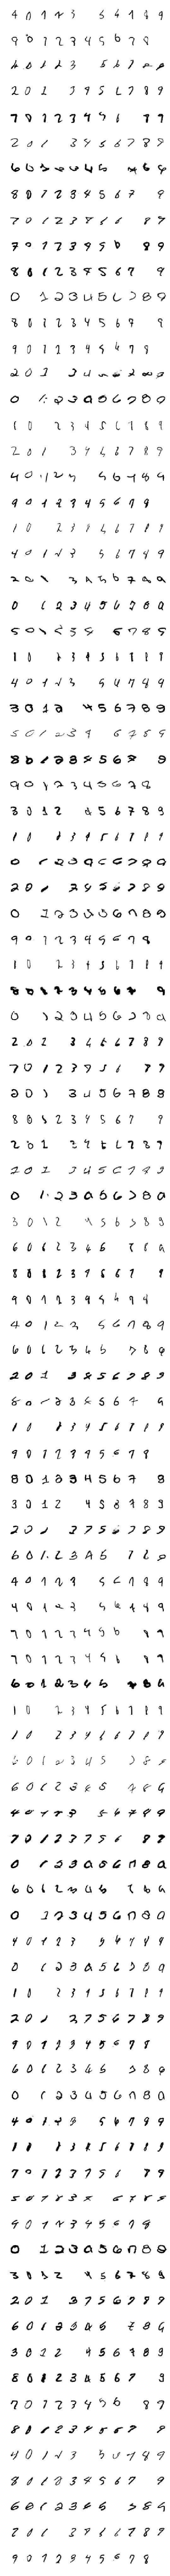

In [12]:
# Plot nearest neighbors for each input
test_xs = np.load("X_test_100.npy")
all_nns = np.load("all_nns.npy")
all_y_nns = np.load("all_y_nns.npy")
all_grids_nns = np.load("all_grids_nns.npy")

fig, ax = plt.subplots(max(len(all_nns), 2), len(all_nns[0])+2, 
                       figsize=(9*1, len(all_nns)*1.5))
[a.axis('off') for a in np.asarray(ax).reshape(-1)]

for i in range(len(all_nns)):
    x = test_xs[i]
    nn_advs = all_nns[i]
    ax[i, 0].imshow(255 - x, cmap='gray')
    for j in range(len(nn_advs)):
        y = all_y_nns[i][j]
        ax[i, 1+y].imshow(255 - nn_advs[j], cmap='gray')
    
plt.show()

In [13]:
def linf_attack(x, nn_adv, eps=0.3):
    x_adv = x.copy().astype(np.float32)
    nn_adv = nn_adv.astype(np.float32)
    
    # if possible, change the pixels to the target value
    idx = np.where((np.abs(nn_adv - x) <= eps*255.) & (x > 0))
    x_adv[idx] = nn_adv[idx]
    
    # otherwise, go as close as possible
    idx = np.where(np.abs(nn_adv - x) > eps*255.)
    sign = np.sign(nn_adv - x)
    x_adv[idx] += sign[idx] * eps * 255.
    
    x_adv = np.clip(x_adv, x.astype(np.float32) - eps*255, x.astype(np.float32) + eps*255)
    x_adv = np.clip(x_adv, 0, 255.)
    
    return x_adv

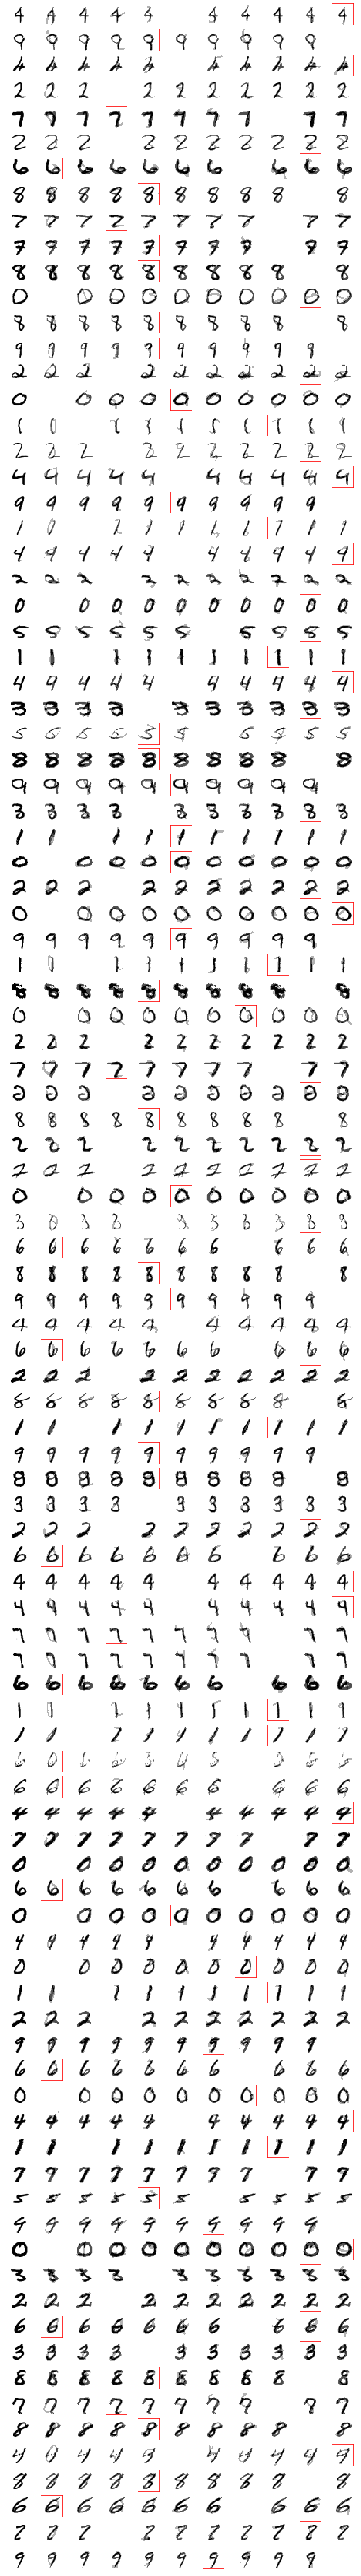

In [14]:
fig, ax = plt.subplots(max(len(all_nns), 2), len(all_nns[0])+2, 
                       figsize=(10*2, len(all_nns)*1.5))
[a.axis('off') for a in np.asarray(ax).reshape(-1)]

# manually chosen target classes for each source class
targets = {
    0: [4, 6, 8, 9],
    1: [4, 6, 7, 9],
    2: [8],
    3: [8],
    4: [8, 9],
    5: [3, 8],
    6: [0],
    7: [2, 3],
    8: [3],
    9: [3, 4, 5]
}

best_y_advs = []
best_targets = []
best_advs = []

for i in range(len(all_nns)):
    x = test_xs[i]
    y = test_ys[i]
    ax[i, 0].imshow(255-x, cmap='gray', vmin=0, vmax=255)
    
    best_x_adv = None
    best_nn_adv = None
    amount_removed = []
    amount_added = []
    rot = []
    best_y = None
    min_removed = np.inf
    for j in range(len(all_nns[i])):
        nn_adv = all_nns[i][j]
        y_nn = all_y_nns[i][j]
        x_adv = linf_attack(x, nn_adv, eps=0.3)
        ax[i, 1+y_nn].imshow(255-x_adv, cmap='gray', vmin=0, vmax=255)
        
        # retain the target that required the least amount of pixels to be "removed"
        curr_rot = np.abs(all_grids_nns[i][j][-1])
        curr_removed = np.sum(np.abs(np.maximum(x/255. - x_adv/255., 0)))
        
        if y_nn in targets[y] and curr_removed < min_removed:
            min_removed = curr_removed
            best_y = y_nn
            best_x_adv = x_adv
            best_nn_adv = (nn_adv, y_nn)
                
    best_targets.append(best_nn_adv)
    best_advs.append(best_x_adv)
    best_y_advs.append(best_y)
    
    ax[i, 1+best_y].axis('on')
    ax[i, 1+best_y].set_xticks([])
    ax[i, 1+best_y].set_yticks([])
    ax[i, 1+best_y].spines['top'].set_color('red')
    ax[i, 1+best_y].spines['bottom'].set_color('red')
    ax[i, 1+best_y].spines['left'].set_color('red')
    ax[i, 1+best_y].spines['right'].set_color('red')
        
plt.show()

In [16]:
np.save("adv_examples.npy", np.reshape(best_advs, (-1, 28, 28)))